In [46]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Brent") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



In [3]:
spot = df1["LCOc1"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
#spot_train.plot()

In [36]:
# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-290.839, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-286.936, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-295.028, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-292.546, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-288.825, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-296.957, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-295.030, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-293.018, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-295.860, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-295.455, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-294.381, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-296.687, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-298.902, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=-296.973, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1

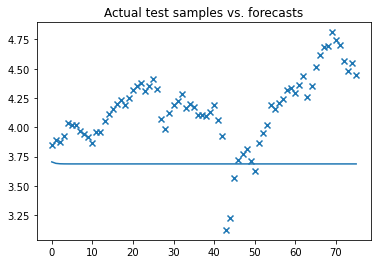

In [37]:
# Fit a simple auto_arima model
autoarima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

#arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      #suppress_warnings=True, maxiter=5,
                      #seasonal=True, m=12)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, autoarima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [38]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 151.451
Date:                Sun, 08 Jan 2023   AIC                           -298.902
Time:                        21:34:10   BIC                           -292.881
Sample:                             0   HQIC                          -296.456
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      0.075      3.757      0.000       0.134       0.427
sigma2         0.0078      0.001     10.617      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.59
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.37
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
### The same with statsmodel package ####

model = ARIMA(spot_train, order=(1,1,0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  LCOc1   No. Observations:                  151
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 151.451
Date:                Sun, 08 Jan 2023   AIC                           -298.902
Time:                        21:34:31   BIC                           -292.881
Sample:                    01-31-2004   HQIC                          -296.456
                         - 07-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      0.075      3.757      0.000       0.134       0.427
sigma2         0.0078      0.001     10.617      0.000       0.006       0.009
Ljung-Box (L1) (Q):                   0.08   Jarque-

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [8]:
#plt.plot(x, arima.predict(n_periods=test.shape[0]))

In [9]:
#arima.predict(n_periods=test.shape[0])

In [41]:
### The same with non-automatic ARIMA from pmdarima ####

ar = pm.ARIMA(order=(1,1,0), with_intercept=False)
ar.fit(spot_train)
ar.summary()

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 151.451
Date:                Sun, 08 Jan 2023   AIC                           -298.902
Time:                        21:36:03   BIC                           -292.881
Sample:                    01-31-2004   HQIC                          -296.456
                         - 07-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      0.075      3.757      0.000       0.134       0.427
sigma2         0.0078      0.001     10.617      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                14.59
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.37
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

In [75]:
#From TDS Medium:

history = [x for x in train]
print(type(history))
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    history.pop(0) ### remove th first element -> rolling window???
error = mean_squared_error(test, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing Mean Squared Error: 0.018
Symmetric mean absolute percentage error: 2.166


In [45]:
#model_fit.summary()

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self.

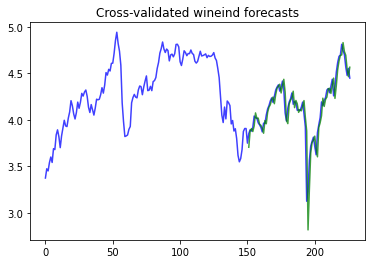

In [79]:
### with pmdarima sliding window ####

cv = SlidingWindowForecastCV(window_size=151)
predictions = model_selection.cross_val_predict(
    ar, spot, cv=cv, verbose=0)

x_axis = np.arange(spot.shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated wineind forecasts")
plt.show()


<AxesSubplot:>

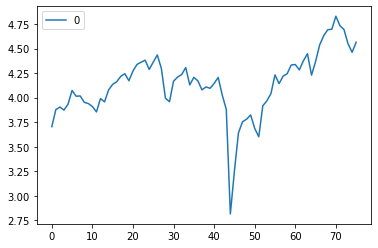

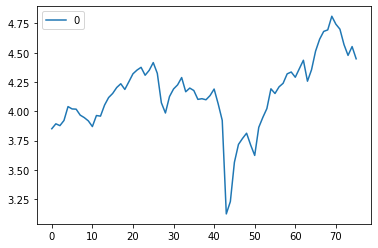

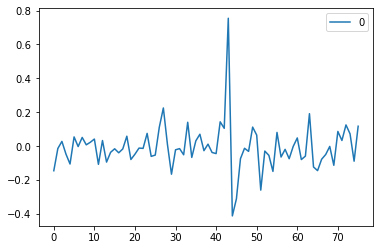

In [25]:
#pd.DataFrame(predictions).plot()
#pd.DataFrame(test).plot()

#pd.DataFrame(predictions-test).plot()

In [80]:
predictions

array([3.70448258, 3.87811029, 3.90436514, 3.87328096, 3.93319015,
       4.07345925, 4.01441511, 4.01743699, 3.95280626, 3.94002601,
       3.91036685, 3.85498918, 3.99069878, 3.95708249, 4.07933705,
       4.13544407, 4.16238382, 4.21737433, 4.24399505, 4.17222583,
       4.27115803, 4.33891635, 4.360631  , 4.38174653, 4.2876352 ,
       4.36155057, 4.43479598, 4.29726391, 3.99530688, 3.9582646 ,
       4.16746163, 4.20948058, 4.23559987, 4.30663724, 4.13016119,
       4.20715497, 4.17079112, 4.07936404, 4.10894712, 4.09551633,
       4.14452286, 4.20590885, 4.02656884, 3.87922688, 2.81599459,
       3.2519773 , 3.64204279, 3.75441645, 3.78074655, 3.82391922,
       3.68759889, 3.60156891, 3.91720411, 3.96754963, 4.04116623,
       4.23173924, 4.14289578, 4.21857117, 4.24372215, 4.33261165,
       4.33770379, 4.28289294, 4.37526716, 4.44735621, 4.22951954,
       4.36733102, 4.53652678, 4.63064242, 4.6917415 , 4.6965087 ,
       4.82909439, 4.73302244, 4.69384898, 4.54871922, 4.46200

In [82]:
#print(predictions)
#print(test)


In [77]:
history = [x for x in train]
print(type(history))
predictions = list()
for t in range(len(test)):
    model = pm.ARIMA(order=(1,1,0), with_intercept=False)
    model_fit = model.fit(history)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    history.pop(0) ### remove th first element -> rolling window???
error = mean_squared_error(test, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing Mean Squared Error: 0.018
Symmetric mean absolute percentage error: 2.166


In [78]:
predictions

[3.7044825764158578,
 3.8781102931997102,
 3.9043651355756754,
 3.8732809642824493,
 3.9331901463642827,
 4.073459245121447,
 4.014415111569803,
 4.017436988282765,
 3.9528062562723134,
 3.940026007352342,
 3.910366849947785,
 3.854989177603594,
 3.990698783787378,
 3.9570824852090625,
 4.079337049159275,
 4.135444065663266,
 4.162383815417126,
 4.217374328260694,
 4.243995051783997,
 4.172225831361594,
 4.27115803177165,
 4.33891635094282,
 4.360631000295269,
 4.381746531729681,
 4.287635204004671,
 4.361550565075901,
 4.434795980811706,
 4.297263911229588,
 3.9953068833956413,
 3.9582646029703596,
 4.167461625479861,
 4.209480580428518,
 4.235599871846194,
 4.306637235344697,
 4.1301611930325866,
 4.207154970746953,
 4.170791119192306,
 4.079364043521086,
 4.108947117432124,
 4.0955163279631535,
 4.1445228571028805,
 4.205908853094185,
 4.026568840236941,
 3.8792268840394155,
 2.8159945888707307,
 3.2519772994669967,
 3.6420427922197103,
 3.7544164527925683,
 3.7807465539449856,
 3.8